In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi
from scipy.stats import linregress

In [9]:
df = pd.read_csv("data.csv")
df["error"] = np.sqrt((df["pi"] - pi) ** 2)

# num_nodes/ranks = {2,4,6,8,16,32,64}
# total_darts = {10^3, 10^6, 10^9}
print(df.head())

   nodes   darts  time       pi     error
0      2  1000.0  0.09  3.12400  0.017593
1      4  1000.0  0.13  3.06000  0.081593
2      8  1000.0  0.16  3.17000  0.028407
3     16  1000.0  0.18  3.13750  0.004093
4     32  1000.0  0.19  3.13125  0.010343


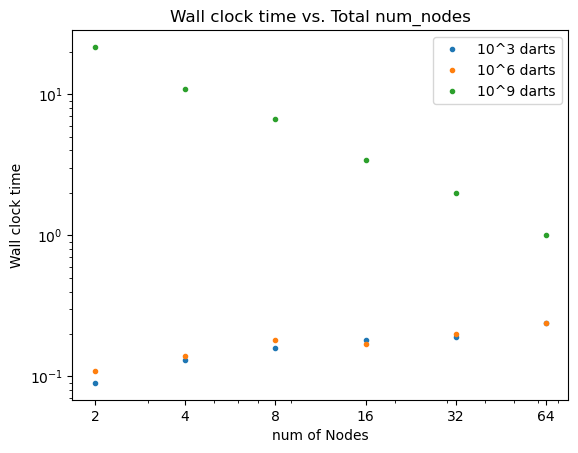

In [18]:
fig, ax = plt.subplots()
for key, grp in df.groupby("darts"):
    grp.plot(ax=ax, label=key, logx=True, logy=True, \
             x="nodes", y="time", kind="line", linestyle='None', marker='.')
ax.set_xlabel("num of Nodes")
ax.set_ylabel("Wall clock time")
plt.title("Wall clock time vs. Total num_nodes")
plt.legend(["10^3 darts", "10^6 darts", "10^9 darts"])
plt.xticks(df["nodes"].unique(), df["nodes"].unique())
plt.savefig("time_scaling.png")

##### **Comments**
- We observed interesting patterns from the plot.  
  Perform the same number of 'rounds' on each rank, when the number of darts is small ($10^3, 10^6$), as the number of nodes increases, the total runtime slightly increases; when the number of darts is larger ($10^9$), as the number of nodes increases, the total runtime obviously decreases.  
     
- This observed behavior is influenced by a balance between **computational workload** and **parallel overhead among the nodes**. In the context of parallel computing, "overhead" refers to the extra work and time required to manage the parallel processes. It includes the time spent on starting up and shutting down the parallel environment, communicating between nodes, synchronizing processes, and any additional operations that are necessary only because the task is being run in parallel rather than sequentially.  

- For a small number of darts, the workload done by each node is quite small, and the overhead of initializing MPI environment, distributing workload among nodes, synchronization(mpi_barrier) and communication(mpi_reduce) can dominate the actual run time. Each node spends more time waiting for synchronization and communication than doing the actual computation. Therefore, there is less workload than overhead, there is not enough computational workload to benefit from the parallel structure, leading to the patterns we observed when num_of_nodes are 10^3, 10^6: the total run time slightly increases as number of nodes increases.  

- For a large number of darts, the workload done by each node is substantial enough so that the time for actual computation is significantly comparable to the overhead time. To be more specific, each node can perform a significant amount of actual computation before need to synchronize or communicate with other nodes. In this case, when the total workload is fixed, as the parallel resources(num_of_nodes) increases, the total run time decreases, which showcases the benefits of parallel computing.

- In summary, what we learned is that for parallel computing, there is a crossover point where the increase in parallel resources starts to show benefits(in this problem, parallel resources are the number of nodes). Below this point, overheads donimate; above this point, actual computation can efficiently utilize the parallel structure.


In [26]:
slopes = {}
for key, group in df.groupby(["nodes"]):
    darts = np.log(group.loc[:, "darts"]) # convert to log scale
    err = np.log(group.loc[:, "error"])   # convert to log scale
    linreg_results = linregress(darts, err)
    slopes[key] = [linreg_results.slope]

mean_errors = []
for key, group in df.groupby(["darts"]):
    errors = group.loc[:, "error"]
    mean_errors.append(errors.mean())

slope_df = pd.DataFrame.from_dict(slopes, orient="index")
#print(slope_df,'\n')

mean_slope = slope_df.mean()
std_slope = slope_df.std()
print("mean slope = {}".format(mean_slope.loc[0]))
print("std slope = {}".format(std_slope.loc[0]))

print(mean_errors)
ideal_curve_domain = np.linspace(1e3, 1e9, 50)
ideal_curve_error = (ideal_curve_domain) ** -0.5

mean slope = -0.4555267716147096
std slope = 0.09486172244259576
[0.02465588452993095, 0.0010215000000000825, 2.9782136735582537e-05]


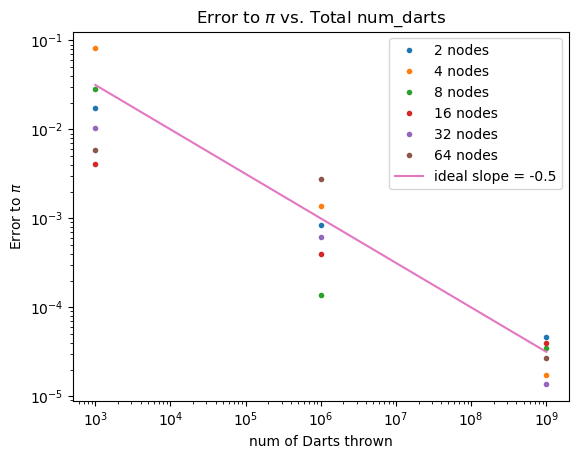

In [28]:
fig2, ax2 = plt.subplots()
for key, grp in df.groupby(["nodes"]):
    grp.plot(ax=ax2, logy=True, logx=True, label=key, \
             x="darts", y="error", kind="line", linestyle='None', marker='.')
ax2.plot(ideal_curve_domain, ideal_curve_error, "-", label="ideal slope = -0.5")
ax2.set_xlabel("num of Darts thrown")
ax2.set_ylabel(f"Error to $\pi$")
plt.legend(["2 nodes", "4 nodes", "8 nodes", "16 nodes", "32 nodes", "64 nodes", "ideal slope = -0.5"])
plt.title(f"Error to $\pi$ vs. Total num_darts")
plt.savefig("error_scaling.png")

##### **Comments**
- We converted *num_of_darts* and *error* into log scale and then computed the slope of the relationship between num_of_darts and the error of estimated Pi value.  

- Slope interpretation  
1) Negativity:   
The negative slope of the line shows that as the number of darts increases, the error decreases.  
  
2) Slope value:   
In an ideal Monte Carlo simulation for estimating Pi, the error should scale with $ \frac{1}{\sqrt{n}}$ where n is num_of_darts, due to *the law of large numbers theory*. This is because the standard deviation of the sample mean in Monte Carlo simulation decreases with $\frac{1}{\sqrt{n}}$ where n is the sample size. In the log-log scale, this relationship would be expected to have a slope of $ -\frac{1}{2}$. In the plot, this ideal $ -\frac{1}{2}$ slope line is shown in pink named 'ideal'.

3) By comparing the slope of lines that drawn from our empirical results with the ideal slope of $ -\frac{1}{2}$, we can assess how well the simulation performs. The closer the empirical slopes are to $ -\frac{1}{2}$, the better the simulation is bahaving as theoretically expected. Our empirical results show that our mean_slope = -.04555 and std_slope = 0.0246, which implies that our simulation of estimating Pi behaves as it is theoretically expected :)
